# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [2]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released

In [3]:
names = ["name", "date", "genre", "url"]
names += ["f" + str(x) for x in range(19)]  # unused feature names

items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', encoding='latin-1',
                    names=names)
# fix a missing value
items.fillna(value="01-Jan-1997", inplace=True)
items.head()

,name,date,genre,url,f0,f1,f2,f3,f4,f5,...,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution

In [4]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [5]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [6]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [7]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [8]:
from keras.layers import Input, Embedding, Flatten, merge, Dense, Dropout, Lambda
from keras.models import Model
import keras.backend as K
from keras_fixes import dot_mode

Using TensorFlow backend.


In [9]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = merge([user_vecs, item_vecs], mode=dot_mode, output_shape=(1,))

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [10]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000,)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitely. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [11]:
# %load solutions/compute_errors.py
squared_differences = np.square(initial_train_preds - rating_train.values)
absolute_differences = np.abs(initial_train_preds - rating_train.values)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so with less numpy engineering 
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#
#print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
#print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


Random init MSE: 13.732
Random init MAE: 3.531


### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [12]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
1s - loss: 2.9793 - val_loss: 1.5083
Epoch 2/6
1s - loss: 1.1274 - val_loss: 0.9971
Epoch 3/6
1s - loss: 0.9474 - val_loss: 0.9486
Epoch 4/6
1s - loss: 0.9212 - val_loss: 0.9343
Epoch 5/6
1s - loss: 0.9126 - val_loss: 0.9293
Epoch 6/6
1s - loss: 0.9088 - val_loss: 0.9263
CPU times: user 22 s, sys: 2.21 s, total: 24.2 s
Wall time: 9.66 s


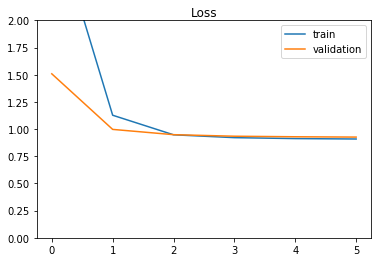

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

Now that the model is trained, the model MSE and MAE look nicer:

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.412
Final test MAE: 0.896


In [15]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 1.407
Final train MAE: 0.898


## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [16]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.99)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(2, activation='tanh')(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='binary_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [17]:
# %load solutions/deep_explicit_feedback_recsys.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
## Error 1: Dropout was too high, preventing any training
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)

## Error 2: output dimension was 2 where we predict only 1-d rating
## Error 3: tanh activation squashes the outputs between -1 and 1
## when we want to predict values between 1 and 5
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input], output=y)
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])


In [18]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
2s - loss: 1.0275 - val_loss: 0.7657
Epoch 2/5
2s - loss: 0.7526 - val_loss: 0.7529
Epoch 3/5
2s - loss: 0.7373 - val_loss: 0.7498
Epoch 4/5
2s - loss: 0.7312 - val_loss: 0.7535
Epoch 5/5
2s - loss: 0.7247 - val_loss: 0.7448
CPU times: user 22.3 s, sys: 1.76 s, total: 24.1 s
Wall time: 10.7 s


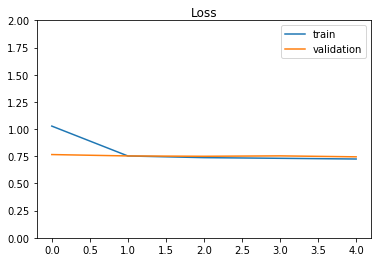

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [20]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.930
Final test MAE: 0.730


In [21]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.870
Final train MAE: 0.699


### Home assignment: 
 - Add another layer, compare train/test error
 - What do you notice? 
 - Try adding more dropout and modifying layer sizes: should you increase
   or decrease the number of parameters

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [22]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]

In [23]:
# Solution: 
# model.summary()

In [24]:
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["name"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

First item name from metadata: Toy Story (1995)
Embedding vector for the first item:
[ 0.06656966 -0.11037975 -0.10096616  0.04138852 -0.05465755 -0.06664473
 -0.05834128 -0.02316108  0.11232883 -0.08162     0.00034907  0.03863313
  0.07503467 -0.038852    0.03839659 -0.09521606  0.08333123  0.09592038
 -0.07425836 -0.00616984 -0.10561048  0.07732547  0.08328027 -0.03731563
 -0.12221446  0.05361582 -0.07965651  0.08811148 -0.03541961  0.0378662 ]
shape: (30,)


### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [25]:
EPSILON = 1e-07

def cosine(x, y):
    # TODO: modify function
    return 0.

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    # TODO: modify function
    return 0.

# Computes top_n most similar items to an idx
def most_similar(idx, top_n=10):
    # TODO: modify function
    idxs = np.array([1,2,3])
    return items["name"][idxs]

most_similar(181)

1     Toy Story (1995)
2     GoldenEye (1995)
3    Four Rooms (1995)
Name: name, dtype: object

In [26]:
# %load solutions/similarity.py
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)

# Computes cosine similarities between x and all item embeddings
def cosine_similarities(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx, 
def most_similar(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode=='euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], dists[idxs]))
    else:
        sims = cosine_similarities(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], sims[idxs]))

# sanity checks:
print("cosine of item 1 and item 1: "
      + str(cosine(item_embeddings[1], item_embeddings[1])))
euc_dists = euclidean_distances(item_embeddings[1])
print(euc_dists.shape)
print(euc_dists[1:5])
print()

# Test on movie 181: Return of the Jedi
print("Items closest to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="euclidean"):
    print(title, dist)


# We observe that the embedding is poor at representing similarities
# between movies, as most distance/similarities are very small/big 
# One may notice a few clusters though
# it's interesting to plot the following distributions
# plt.hist(euc_dists)

# The reason for that is that the number of ratings is low and the embedding
# does not automatically capture semantic relationships in that context. 
# Better representations arise with higher number of ratings, and less overfitting models


cosine of item 1 and item 1: 0.99999937543
(1683,)
[ 0.          0.42952365  0.54374003  0.36132884]

Items closest to 'Return of the Jedi':
Return of the Jedi (1983) 0.0
Marlene Dietrich: Shadow and Light (1996)  0.198019
Big Night (1996) 0.206246
Great Day in Harlem, A (1994) 0.210658
Dead Poets Society (1989) 0.224183
Spanish Prisoner, The (1997) 0.235339
Object of My Affection, The (1998) 0.238797
Hoop Dreams (1994) 0.241199
Bridge on the River Kwai, The (1957) 0.241458
Terminator 2: Judgment Day (1991) 0.243554


### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [27]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

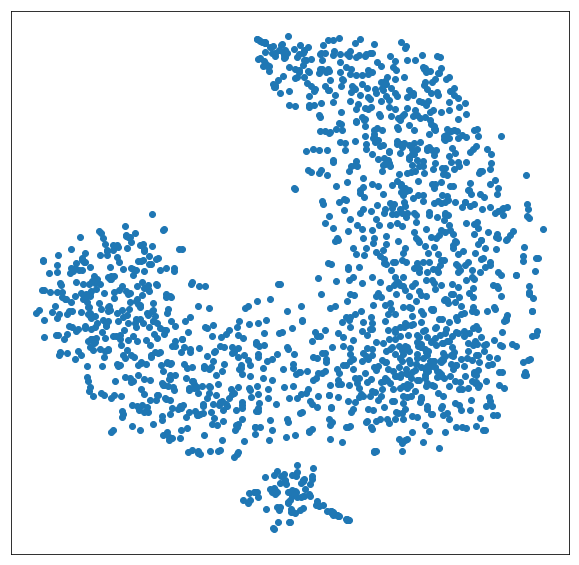

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [29]:
# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]

len(item_meta_train), len(item_meta_test)

(80000, 20000)

In [30]:
items["scaled_date"].describe()

count    1.682000e+03
mean    -2.129094e-15
std      1.000297e+00
min     -4.730390e+00
25%      2.533563e-01
50%      3.937435e-01
75%      4.639372e-01
max      6.043244e-01
Name: scaled_date, dtype: float64

In [31]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [32]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, nb_epoch=15, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
2s - loss: 0.9585 - val_loss: 0.7708
Epoch 2/15
2s - loss: 0.7618 - val_loss: 0.7567
Epoch 3/15
2s - loss: 0.7345 - val_loss: 0.7486
Epoch 4/15
2s - loss: 0.7149 - val_loss: 0.7369
Epoch 5/15
2s - loss: 0.6984 - val_loss: 0.7341
Epoch 6/15
2s - loss: 0.6866 - val_loss: 0.7320
Epoch 7/15
2s - loss: 0.6765 - val_loss: 0.7260
Epoch 8/15
2s - loss: 0.6686 - val_loss: 0.7272
Epoch 9/15
2s - loss: 0.6615 - val_loss: 0.7241
Epoch 10/15
2s - loss: 0.6536 - val_loss: 0.7359
Epoch 11/15
2s - loss: 0.6474 - val_loss: 0.7256
Epoch 12/15
2s - loss: 0.6428 - val_loss: 0.7282
Epoch 13/15
2s - loss: 0.6396 - val_loss: 0.7318
Epoch 14/15
2s - loss: 0.6344 - val_loss: 0.7272
Epoch 15/15
2s - loss: 0.6310 - val_loss: 0.7298
CPU times: user 1min 10s, sys: 5.63 s, total: 1min 16s
Wall time: 35.2 s


In [33]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test Loss: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test Loss: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test Loss: 0.951
Final test Loss: 0.716


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [34]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"]==user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))
    
    print("user "+str(user_id) +" has seen "+str(len(seen_movies)) + " movies. "+
          "Computing ratings for "+str(len(item_ids))+ " other movies")
    
    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    user[:]=user_id
    items_meta = items["scaled_date"][item_ids].values
    
    rating_preds = model.predict([user, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:,0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [35]:
recommend(3)

user 3 has seen 54 movies. Computing ratings for 1627 other movies


[('Hurricane Streets (1998)', 4.7211957),
 ('A Chef in Love (1996)', 4.2912731),
 ('Swept from the Sea (1997)', 4.290678),
 ('Ladybird Ladybird (1994)', 4.2575731),
 ('Mr. Jones (1993)', 4.1764994),
 ('Fair Game (1995)', 4.1245012),
 ('Jade (1995)', 4.078476),
 ('Spitfire Grill, The (1996)', 4.0770955),
 ('Land Before Time III: The Time of the Great Giving (1995) (V)', 4.071094),
 ('Harold and Maude (1971)', 4.0549202)]

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [36]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

Random init MSE: 3.158
Random init MAE: 1.440
Train on 72000 samples, validate on 8000 samples
Epoch 1/6
2s - loss: 1.3652 - val_loss: 1.2871
Epoch 2/6
2s - loss: 1.2795 - val_loss: 1.2724
Epoch 3/6
2s - loss: 1.2620 - val_loss: 1.2688
Epoch 4/6
2s - loss: 1.2514 - val_loss: 1.2656
Epoch 5/6
2s - loss: 1.2438 - val_loss: 1.2601
Epoch 6/6
2s - loss: 1.2365 - val_loss: 1.2557
Final test MSE: 1.149
Final test MAE: 0.716


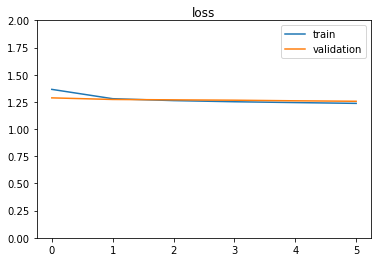

In [37]:
# %load solutions/classification.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 16
dense_size = 128
dropout_embedding = 0.5
dropout_hidden = 0.2

user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(dropout_embedding)(input_vecs)

x = Dense(dense_size, activation='relu')(input_vecs)
x = Dropout(dropout_hidden)(x)
x = Dense(dense_size, activation='relu')(x)
y = Dense(output_dim=5, activation='softmax')(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train]).argmax(axis=1) + 1
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


history = model.fit([user_id_train, item_id_train], rating_train - 1,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True, verbose=2)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');

test_preds = model.predict([user_id_test, item_id_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
